In [1]:
import sys
import logging
import pickle
import yaml
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from catcher_alt1 import MyEnv as catcher_env
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy

In [2]:
nn_yaml = 'network_simpler.yaml'
internal_dim = 5
fname = 'foraging_test'
set_network = None #['foraging_mb', 30, True]

In [3]:
parameters = {
    'nn_yaml': nn_yaml,
    'higher_dim_obs': True,
    'internal_dim': internal_dim,
    'fname': fname,
    'steps_per_epoch': 1000,
    'epochs': 40,
    'steps_per_test': 1000,
    'period_btw_summary_perfs': 1,
    'encoder_type': 'regular',
    'frame_skip': 2,
    'learning_rate': 1*1E-4,
    'learning_rate_decay': 1.0,
    'discount': 0.9,
    'epsilon_start': 1.0,
    'epsilon_min': 1.0,
    'epsilon_decay': 1000,
    'update_frequency': 1,
    'replay_memory_size': 100000, #50000
    'batch_size': 64,
    'freeze_interval': 1000,
    'deterministic': False,
    #'loss_weights': [0, 1E-3, 1E-3, 0, 0, 1E-2, 1., 0],
    'loss_weights': [0, 0, 0, 0, 0, 0, 1., 0.],
    #'loss_weights': [1E-2, 1E-3, 1E-3, 0, 0, 1E-2, 1., 0],
    }

In [4]:
# --- Instantiate environment ---
rng = np.random.RandomState()
env = catcher_env(
    rng, higher_dim_obs=parameters['higher_dim_obs'], reverse=False
    )

# Algorithm
learning_algo = CRAR(
    env, parameters['freeze_interval'], parameters['batch_size'], rng,
    high_int_dim=False, internal_dim=parameters['internal_dim'],
    lr=parameters['learning_rate'], nn_yaml=parameters['nn_yaml'],
    double_Q=True, loss_weights=parameters['loss_weights'],
    encoder_type=parameters['encoder_type']
    )

# Policies
train_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.2)
test_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.)

# Initialize Agent
agent = NeuralAgent(
    env, learning_algo, parameters['replay_memory_size'], 1,
    parameters['batch_size'], rng,
    train_policy=train_policy, test_policy=test_policy)
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(10, 500)

# Attach controllers
agent.attach(bc.VerboseController( evaluate_on='epoch', periodicity=1))
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters['learning_rate'],
    learning_rate_decay=parameters['learning_rate_decay'],
    periodicity=1))
agent.attach(bc.TrainerController(
    evaluate_on='action', periodicity=parameters['update_frequency'],
    show_episode_avg_V_value=True, show_avg_Bellman_residual=True))
best_controller = bc.FindBestController(
    validationID=catcher_env.VALIDATION_MODE,
    testID=None, unique_fname=fname, savefrequency=5)
agent.attach(best_controller)
agent.attach(bc.InterleavedTestEpochController(
    id=catcher_env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],
    periodicity=1, show_score=True, summarize_every=1, unique_fname=fname))

In [5]:
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(parameters['epochs'], parameters['steps_per_epoch'])

Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.1178, -0.0972, -0.0590,  0.0703, -0.0267], device='cuda:0') tensor([ 0.0433, -0.0537,  0.2479, -0.0130, -0.3698], device='cuda:0') tensor([-0.1242, -0.0983, -0.0592,  0.0676, -0.0309], device='cuda:0')
R[0]
tensor([0.2437], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.8748687323596742
Episode average V value: -0.0493636354804039
Average (on the epoch) training loss: 0.5492462767633023
Episode average V value: 0.26382434243957203
Average (on the epoch) training loss: 0.4101694753063307
Episode average V value: 0.6669745763142904
Average (on the epoch) training loss: 0.3730430276247493
Episode average V value: 0.6534247795740763
Average (on the epoch) training loss: 0.34594091266349314
Episode average V value: 0.7006344199180603
Average (on the epoch) training loss: 0.2443654533398811
Episode average V value: 0

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Testing score per episode (id: 0) is 56.94117647058823 (average over 17 episode(s))
== Mean score per episode is 56.940841524461625 over 17 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:113: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  all_possib_inp = torch.tensor(all_possib_inp).to(
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 2.5803, -2.5766, -4.1864, -2.9682,  2.7995], device='cuda:0') tensor([ 2.6224, -3.3087, -4.4470, -3.2275,  2.8384], device='cuda:0') tensor([ 2.5533, -2.5643, -4.1505, -3.0191,  2.8766], device='cuda:0')
R[0]
tensor([0.5208], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.1511114974024618
Episode average V value: 1.3802483456915822
Average (on the epoch) training loss: 0.1507889698278011
Episode average V value: 0.9063082635402679
Average (on the epoch) training loss: 0.15077124652797702
Episode average V value: 1.5236965815226238
Average (on the epoch) training loss: 0.14126676067071794
Episode average V value: 1.4246818047982674
Average (on the epoch) training loss: 0.13178707152308727
Episode average V value: 1.541938258541955
Average (on the epoch) training loss: 0.12045188923366368
Episode average V value: 1

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 4.3789, -3.7510, -7.6055, -2.9377,  4.7484], device='cuda:0') tensor([ 4.4133, -4.8626, -7.9995, -3.1570,  4.9256], device='cuda:0') tensor([ 4.3873, -3.9156, -7.6445, -3.1215,  4.8661], device='cuda:0')
R[0]
tensor([0.6574], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.09218464644027898
Episode average V value: 2.0913320187456117
Average (on the epoch) training loss: 0.08050757661875751
Episode average V value: 2.0914311075494405
Average (on the epoch) training loss: 0.07826403032103375
Episode average V value: 1.9919844998253717
Average (on the epoch) training loss: 0.07337039252212108
Episode average V value: 1.9439384679735443
Average (on the epoch) training loss: 0.07323036117084099
Episode average V value: 1.9091845378279686
Average (on the epoch) training loss: 0.0733988507738526
Episode average V value:

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([  6.3496,  -4.0072, -10.3281,  -3.2054,   7.0978], device='cuda:0') tensor([  6.1213,  -5.3829, -10.9596,  -3.3575,   7.2641], device='cuda:0') tensor([  6.6043,  -3.7719, -10.4408,  -2.5297,   6.7118], device='cuda:0')
R[0]
tensor([0.7439], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.15374282797399377
Episode average V value: 2.690810549643732
Average (on the epoch) training loss: 0.14990506992778843
Episode average V value: 3.009810656309128
Average (on the epoch) training loss: 0.14371287010859674
Episode average V value: 2.909778846634759
Average (on the epoch) training loss: 0.13758421780634128
Episode average V value: 2.2264340586132474
Average (on the epoch) training loss: 0.1318079262578653
Episode average V value: 2.450073812367781
Average (on the epoch) training loss: 0.13056571079362342
Episode avera

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 4.1948, -1.0175, -6.6751, -2.3176,  6.9256], device='cuda:0') tensor([ 3.4244, -1.6478, -7.0777, -2.3877,  6.6872], device='cuda:0') tensor([ 1.6882,  3.0610, -2.6371, -5.0417,  9.9370], device='cuda:0')
R[0]
tensor([0.4896], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.2150255514392888
Episode average V value: 3.027025451193323
Average (on the epoch) training loss: 0.21243987724891092
Episode average V value: 2.89698788523674
Average (on the epoch) training loss: 0.20111671653004332
Episode average V value: 3.3436451256275177
Average (on the epoch) training loss: 0.19631026322810502
Episode average V value: 3.325793981552124
Average (on the epoch) training loss: 0.1918802832170493
Episode average V value: 2.3368162280983396
Average (on the epoch) training loss: 0.18455876360980536
Episode average V value: 3.08

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([  9.5509,  -5.8750, -14.5908,  -4.3098,  10.1448], device='cuda:0') tensor([  9.1836,  -7.8013, -15.8587,  -4.5620,  10.5977], device='cuda:0') tensor([  9.3609,  -6.6704, -14.3451,  -3.6910,   8.8716], device='cuda:0')
R[0]
tensor([1.0506], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.23757303874640737
Episode average V value: 3.4236914237833913
Average (on the epoch) training loss: 0.22983437744463145
Episode average V value: 3.1982608051861035
Average (on the epoch) training loss: 0.2324342637457737
Episode average V value: 3.4899111000391154
Average (on the epoch) training loss: 0.22773840424062333
Episode average V value: 3.2338082641363144
Average (on the epoch) training loss: 0.21829300268938015
Episode average V value: 3.5262491519634542
Average (on the epoch) training loss: 0.22246001049267364
Episode a

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 10.9561,  -5.7108, -16.1002,  -5.9038,  12.6651], device='cuda:0') tensor([ 10.2942,  -7.8975, -17.6460,  -6.1683,  13.0540], device='cuda:0') tensor([ 10.6700,  -5.7685, -16.1180,  -5.6927,  12.4736], device='cuda:0')
R[0]
tensor([1.1351], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.3232913783027066
Episode average V value: 4.086699485778809
Average (on the epoch) training loss: 0.28088307266293594
Episode average V value: 4.037967711440788
Average (on the epoch) training loss: 0.2772340527105068
Episode average V value: 4.236168059209983
Average (on the epoch) training loss: 0.2722359336816371
Episode average V value: 3.968914376364814
LOSSES
T = 4.009849801063537; R = 0.08751579604297877;                 Gamma = 6.426933100700379; Q = 0.2637532703652978;
Entropy Neighbor = 0.09416596455872059;              

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 11.9701, -10.6363, -17.8722,  -4.7977,   9.6207], device='cuda:0') tensor([ 12.2569, -13.2594, -19.6588,  -5.3478,  10.8030], device='cuda:0') tensor([ 11.6682, -10.4320, -17.3695,  -4.6013,   9.2068], device='cuda:0')
R[0]
tensor([1.3925], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.3169086427284927
Episode average V value: 4.337156944173985
Average (on the epoch) training loss: 0.31167632820843544
Episode average V value: 4.184911268728751
Average (on the epoch) training loss: 0.27764215625374933
Episode average V value: 4.3685473512102675
Average (on the epoch) training loss: 0.27810460474698784
Episode average V value: 3.8891083547047205
LOSSES
T = 4.641799545288086; R = 0.10858112467825412;                 Gamma = 6.9153154163360595; Q = 0.27596777659188954;
Entropy Neighbor = 0.07587210533022881;        

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 12.9703, -10.4293, -19.2654,  -5.2650,  11.3843], device='cuda:0') tensor([ 13.1191, -13.2608, -20.9977,  -5.7089,  12.4408], device='cuda:0') tensor([ 12.7126,  -7.8470, -19.1974,  -5.9646,  13.4731], device='cuda:0')
R[0]
tensor([1.3624], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.42479110178020263
Episode average V value: 5.099620145909927
Average (on the epoch) training loss: 0.3134624688015654
Episode average V value: 4.726148827631671
Average (on the epoch) training loss: 0.3128702700264568
Episode average V value: 5.202627976735433
Average (on the epoch) training loss: 0.31264093047594305
Episode average V value: 4.504567601062633
Average (on the epoch) training loss: 0.3120513626474551
Episode average V value: 4.713458403944969
Average (on the epoch) training loss: 0.31125982728439805
Episode average 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_alt1.py:185: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 14.7019,  -5.6621, -19.9810,  -7.0657,  16.4938], device='cuda:0') tensor([ 13.5878,  -8.3771, -21.9037,  -7.1528,  16.7064], device='cuda:0') tensor([ 14.6730,  -5.5273, -19.9105,  -6.8867,  16.2498], device='cuda:0')
R[0]
tensor([1.1936], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.36134231329346317
Episode average V value: 4.640556608509813



KeyboardInterrupt



# Visualize performance

In [7]:
agent.setNetwork(f'{fname}/fname', nEpoch=5)

In [8]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

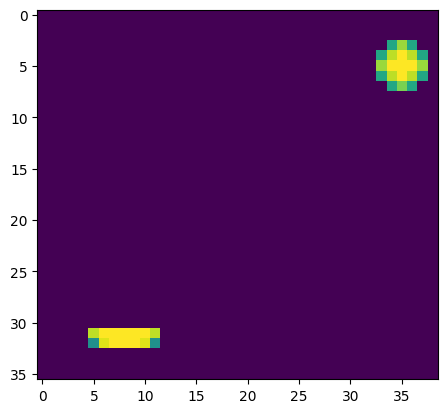

tensor(1, device='cuda:0')


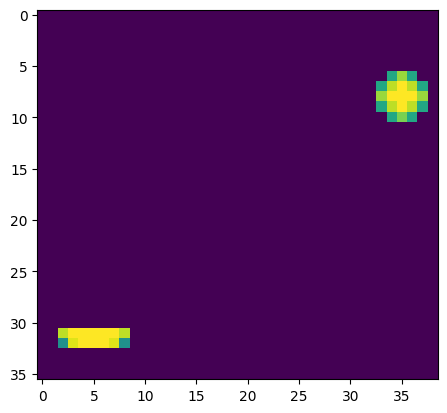

tensor(1, device='cuda:0')


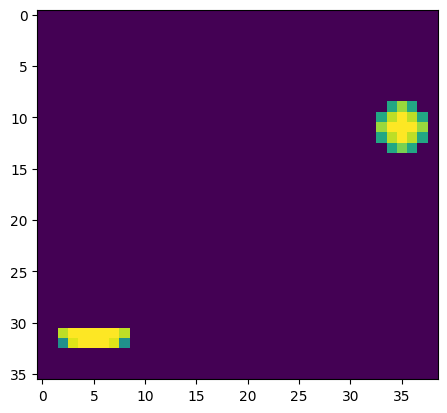

tensor(0, device='cuda:0')


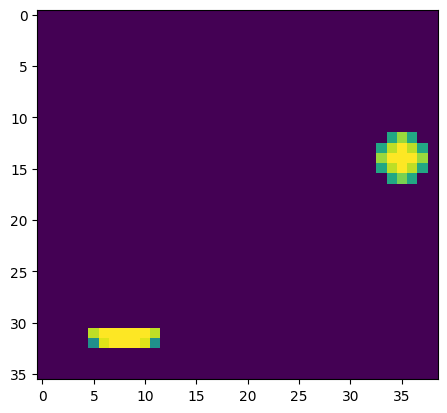

tensor(1, device='cuda:0')


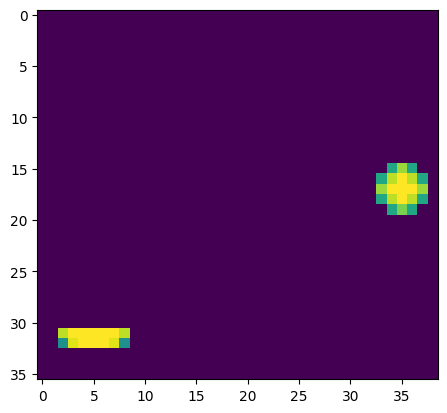

tensor(1, device='cuda:0')


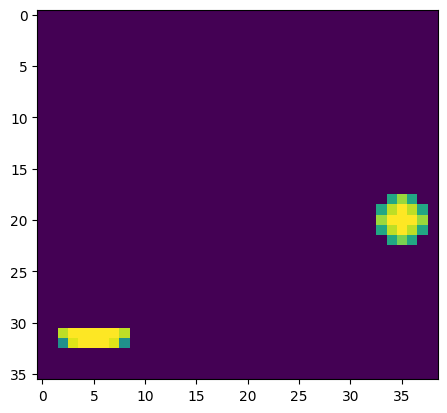

tensor(1, device='cuda:0')


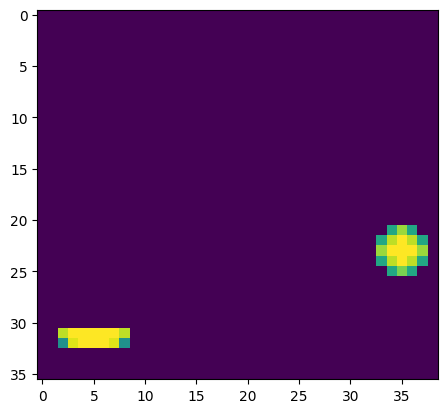

tensor(0, device='cuda:0')


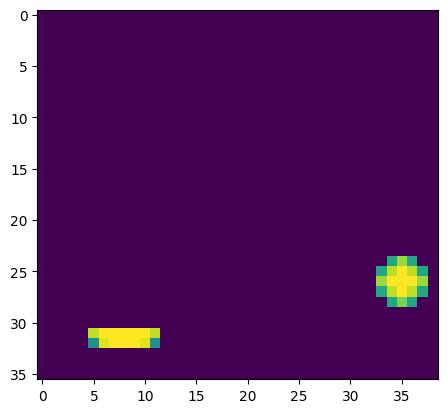

tensor(1, device='cuda:0')


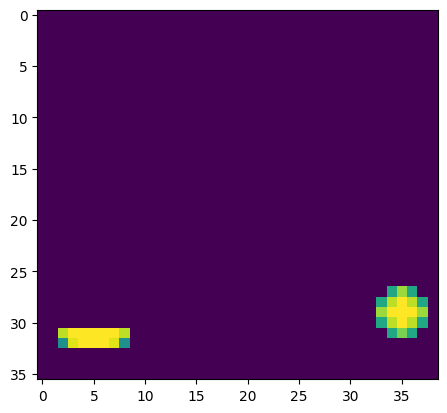

tensor(1, device='cuda:0')


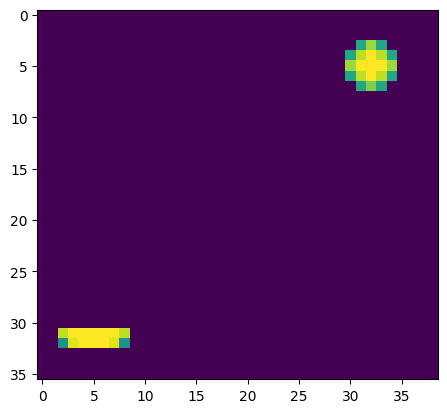

tensor(0, device='cuda:0')


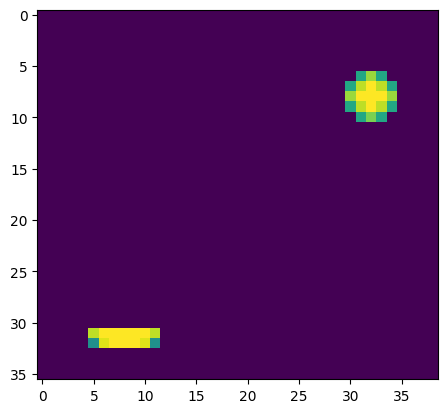

tensor(1, device='cuda:0')


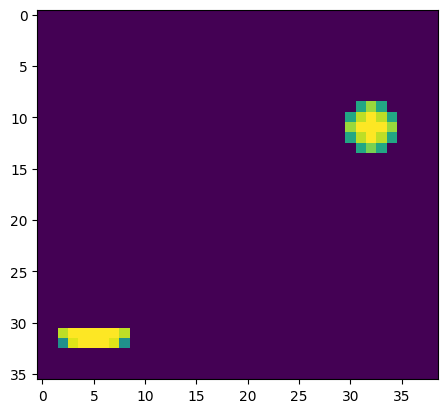

tensor(0, device='cuda:0')


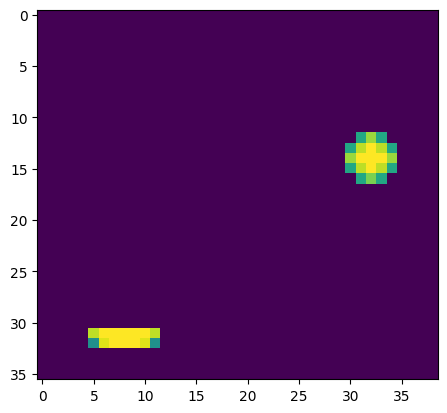

tensor(1, device='cuda:0')


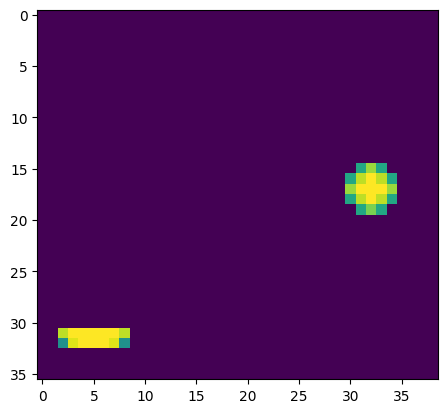

tensor(1, device='cuda:0')


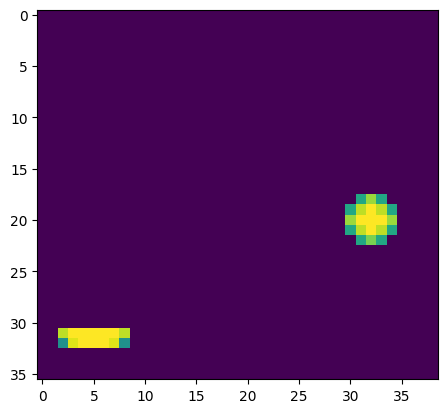

tensor(1, device='cuda:0')


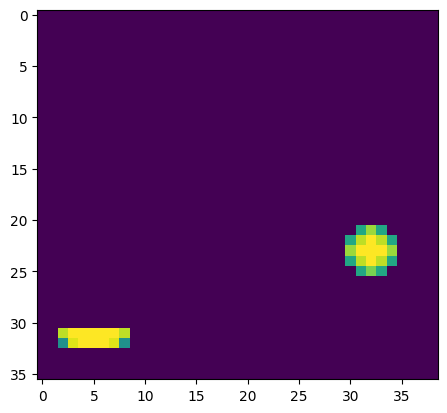

tensor(0, device='cuda:0')


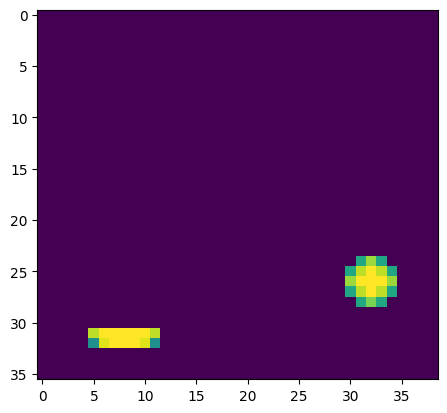

tensor(1, device='cuda:0')


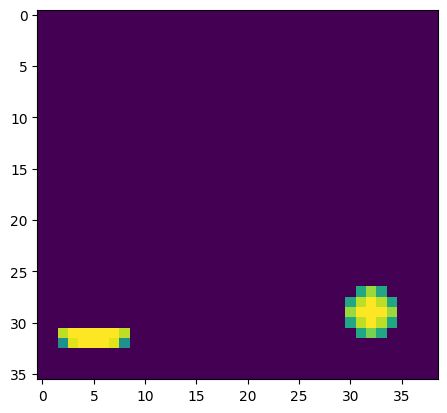

tensor(1, device='cuda:0')


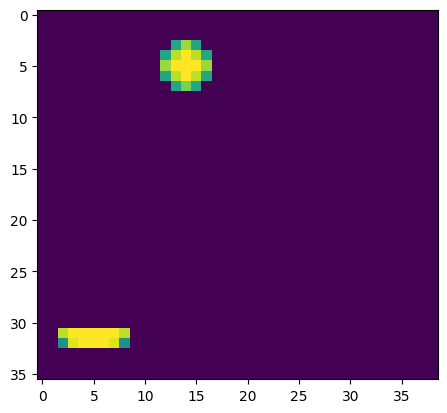

tensor(0, device='cuda:0')


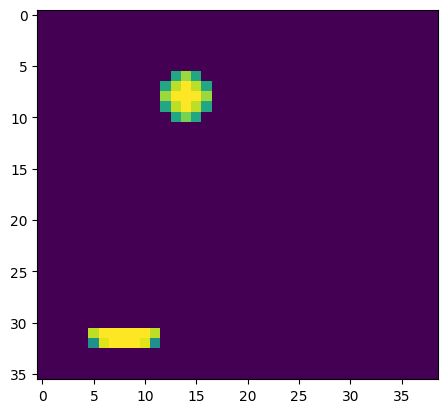

tensor(1, device='cuda:0')


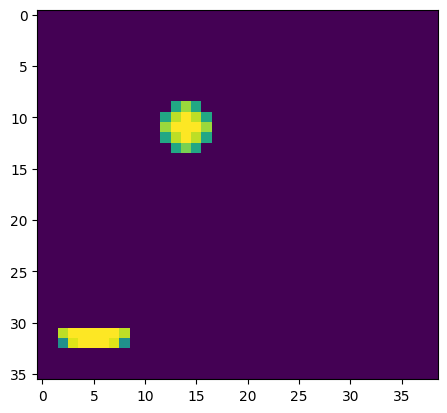

tensor(1, device='cuda:0')


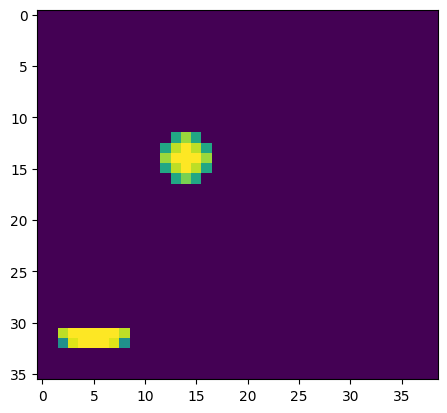

tensor(0, device='cuda:0')


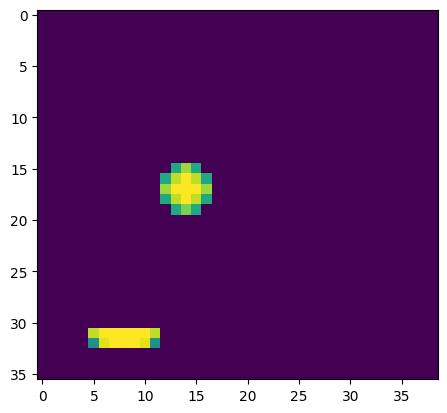

tensor(1, device='cuda:0')


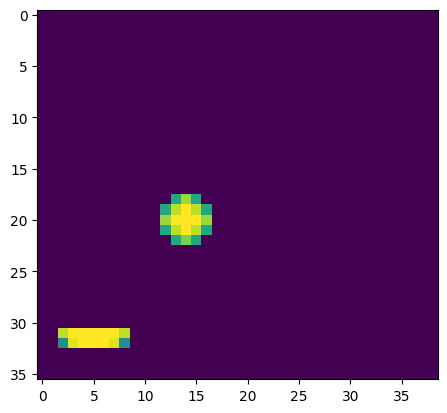

tensor(1, device='cuda:0')


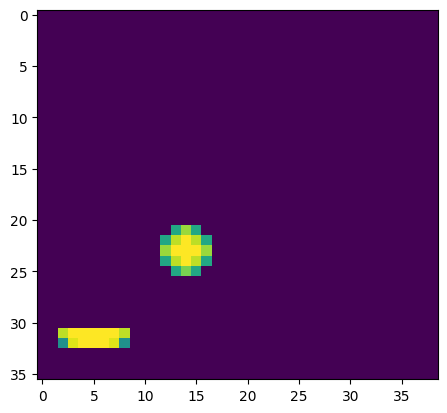

tensor(0, device='cuda:0')


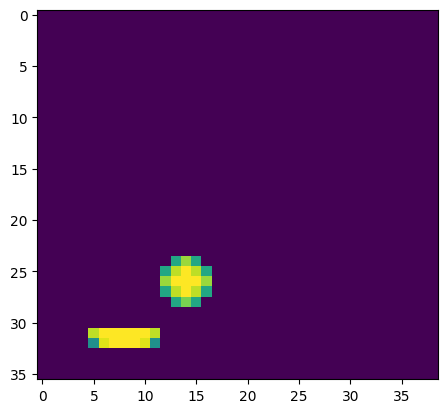

tensor(1, device='cuda:0')


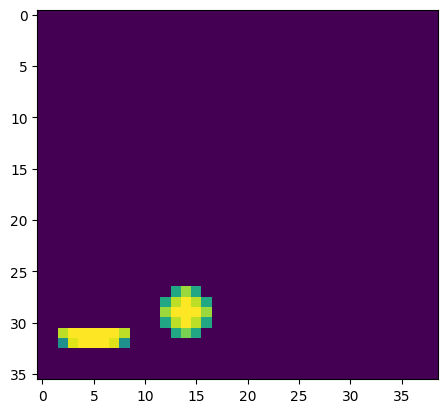

tensor(1, device='cuda:0')


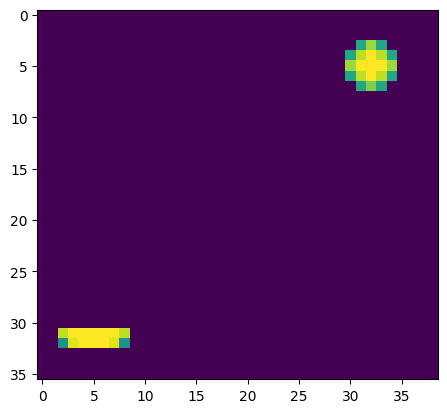

tensor(0, device='cuda:0')


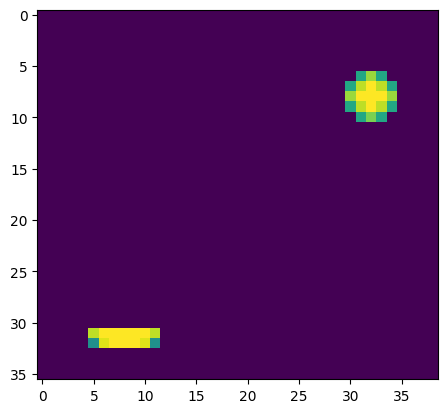

tensor(1, device='cuda:0')


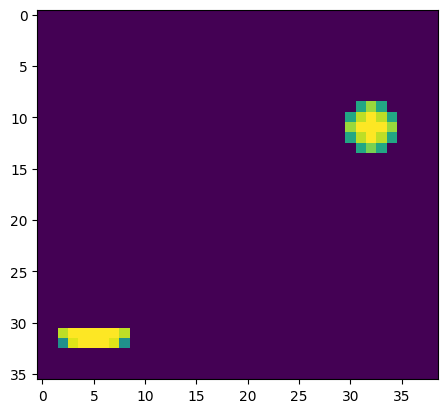

tensor(0, device='cuda:0')


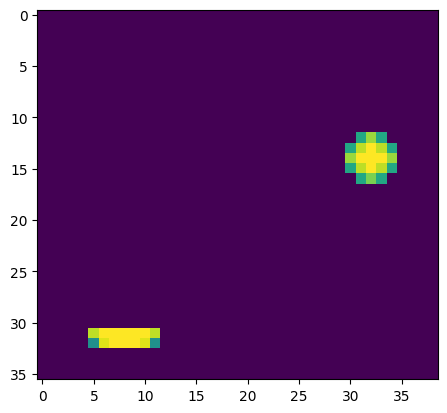

tensor(1, device='cuda:0')


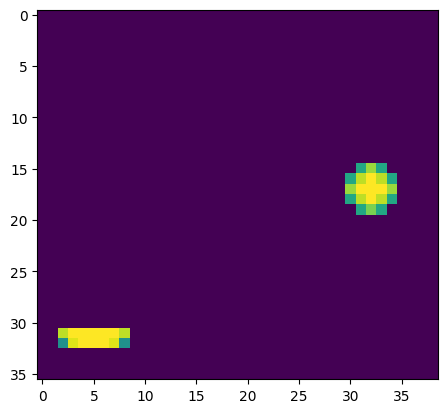

tensor(1, device='cuda:0')


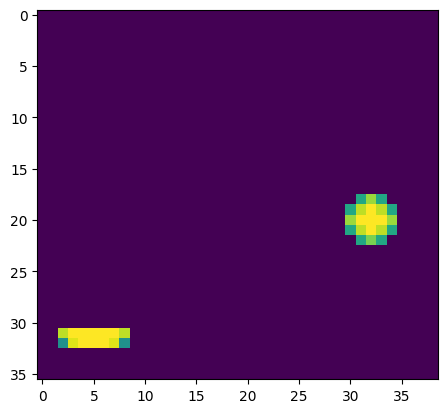

tensor(1, device='cuda:0')


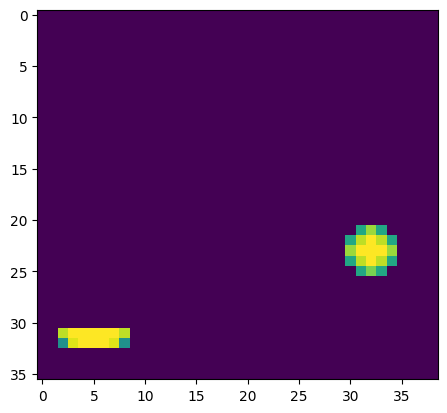

tensor(0, device='cuda:0')


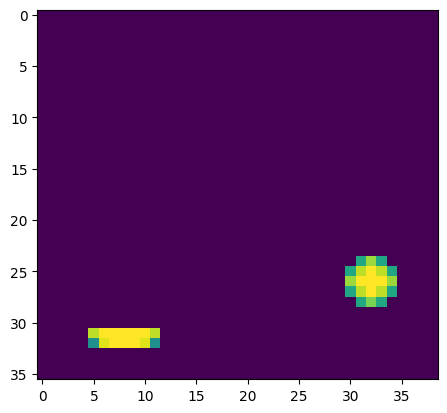

tensor(1, device='cuda:0')


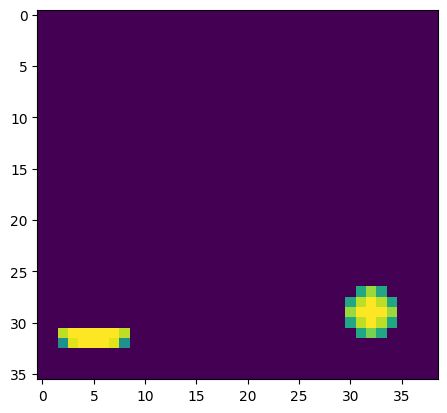

tensor(1, device='cuda:0')


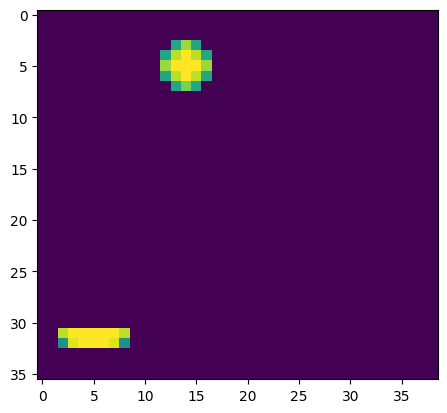

tensor(0, device='cuda:0')


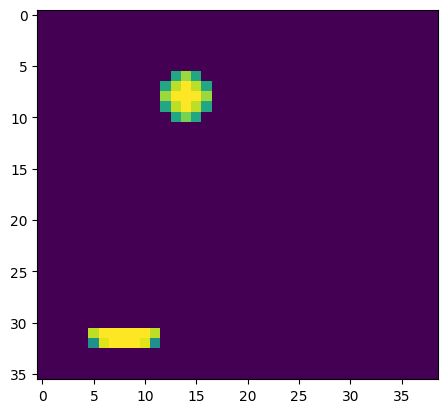

tensor(1, device='cuda:0')


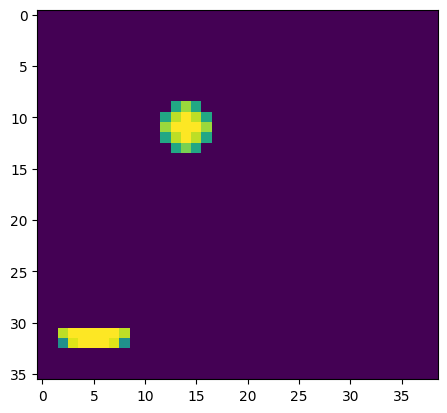

tensor(1, device='cuda:0')


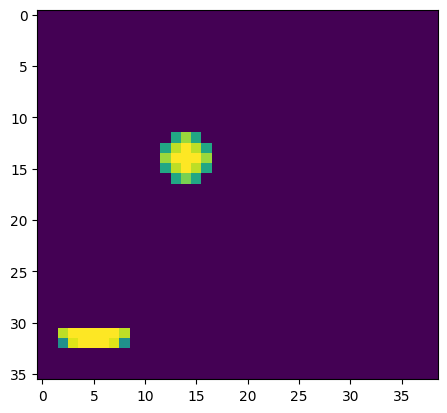

tensor(0, device='cuda:0')


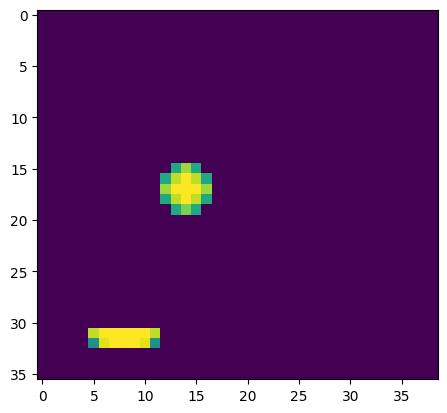

tensor(1, device='cuda:0')


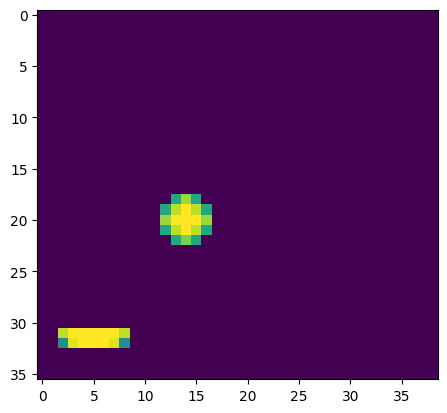

tensor(1, device='cuda:0')


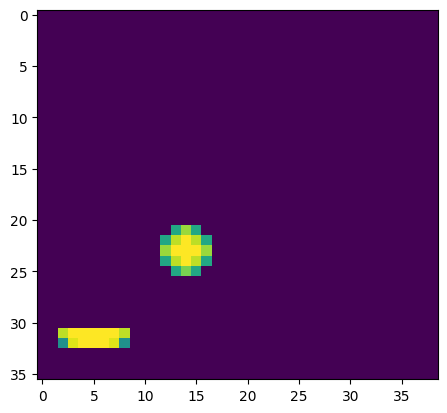

tensor(0, device='cuda:0')


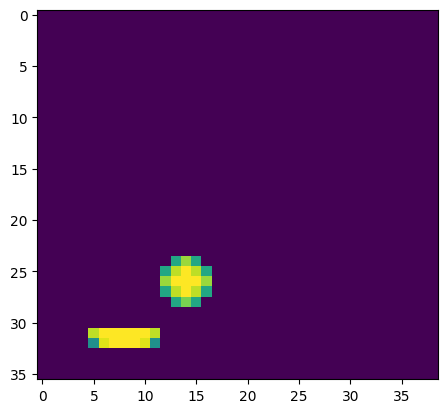

tensor(1, device='cuda:0')


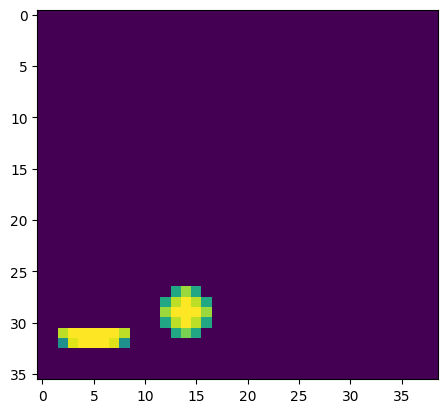

tensor(1, device='cuda:0')


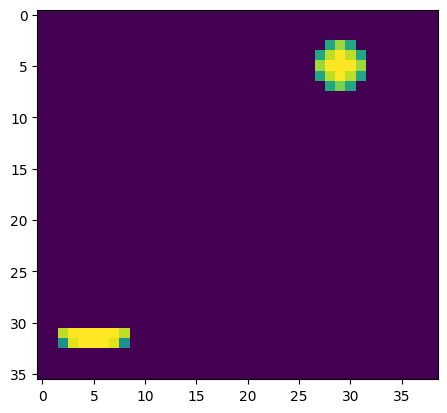

tensor(0, device='cuda:0')


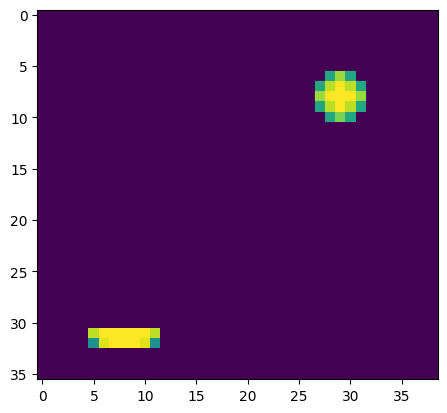

tensor(1, device='cuda:0')


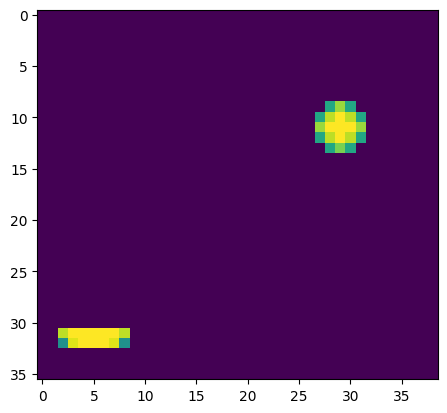

tensor(0, device='cuda:0')


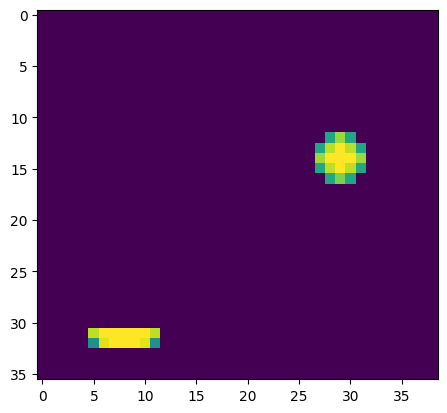

tensor(1, device='cuda:0')


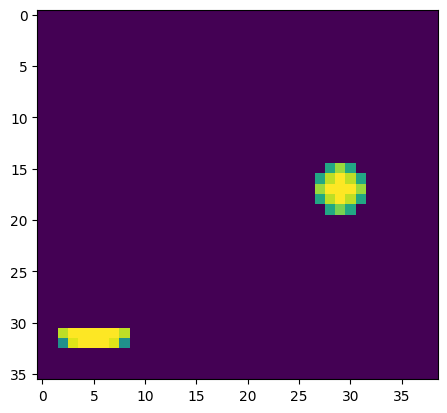

tensor(1, device='cuda:0')


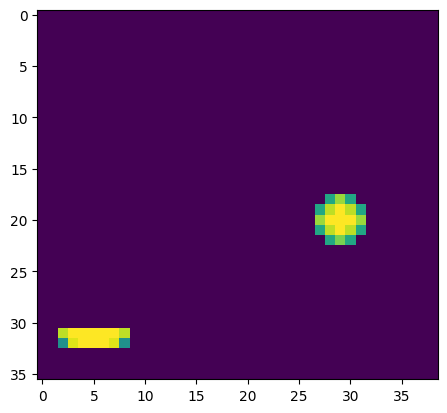

tensor(1, device='cuda:0')


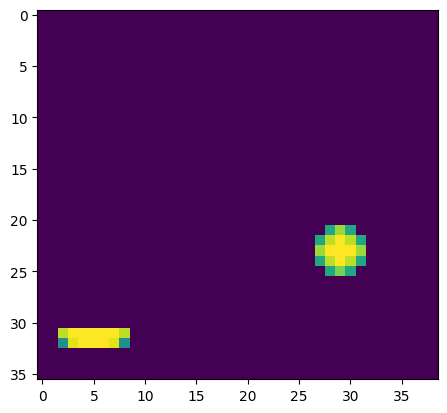

tensor(0, device='cuda:0')


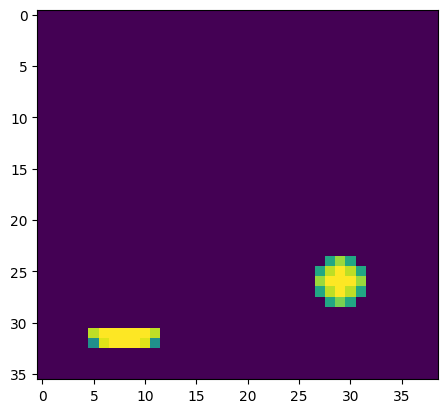

tensor(1, device='cuda:0')


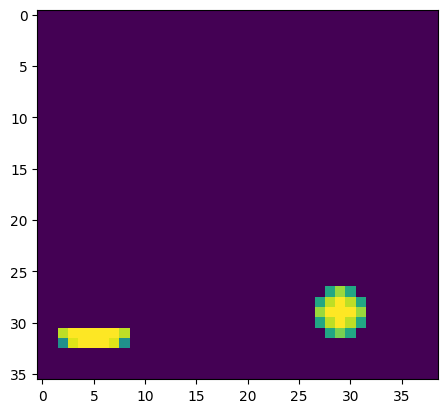

tensor(1, device='cuda:0')


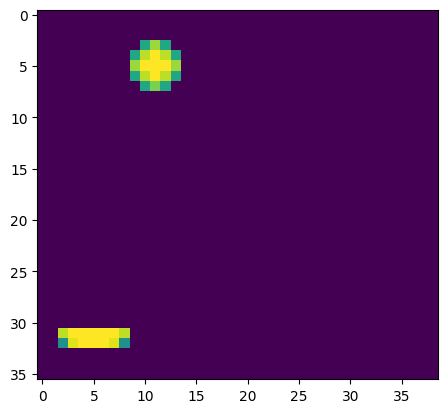

tensor(0, device='cuda:0')


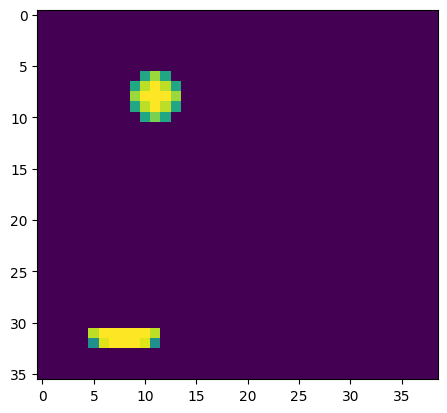

tensor(1, device='cuda:0')


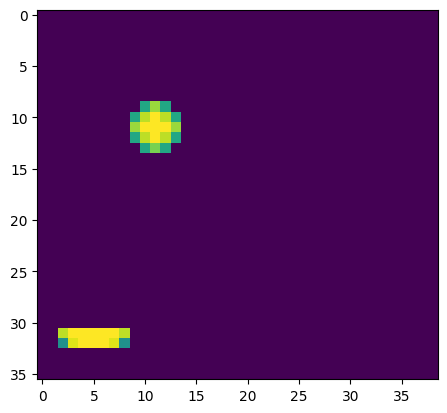

tensor(0, device='cuda:0')


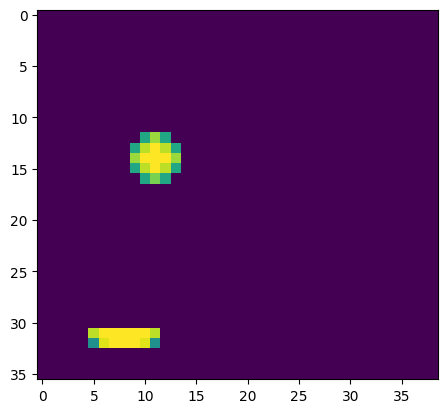

tensor(1, device='cuda:0')


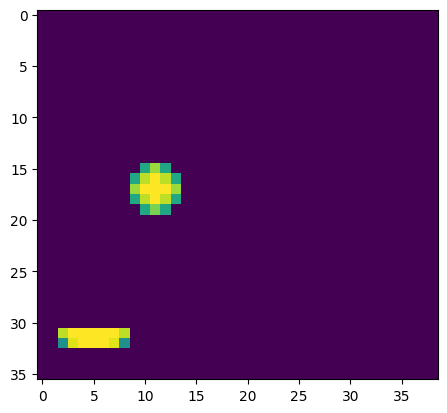

tensor(0, device='cuda:0')


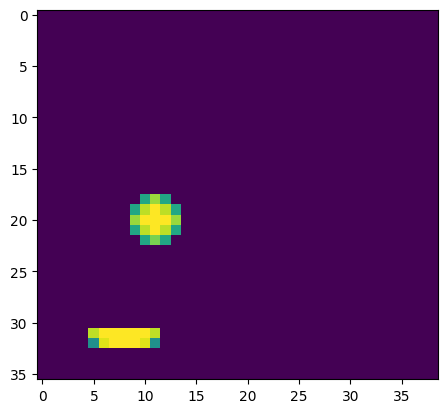

tensor(1, device='cuda:0')


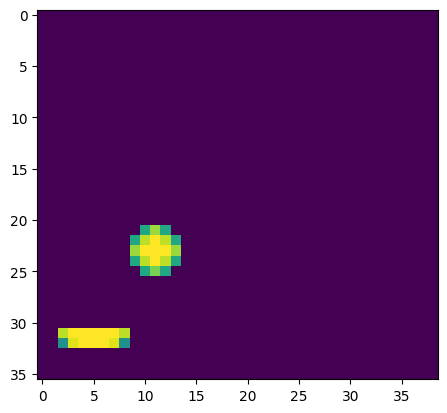

tensor(1, device='cuda:0')


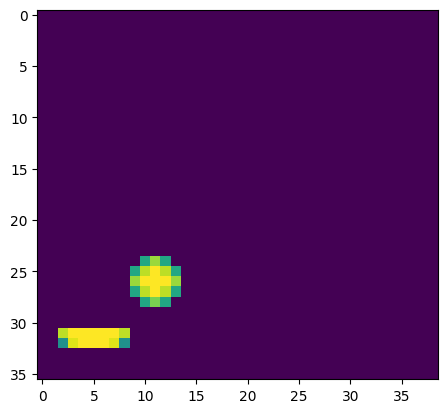

tensor(1, device='cuda:0')


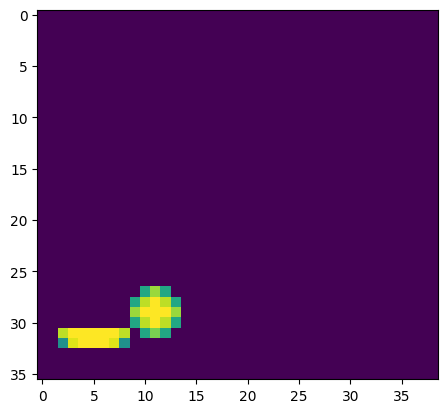

tensor(1, device='cuda:0')


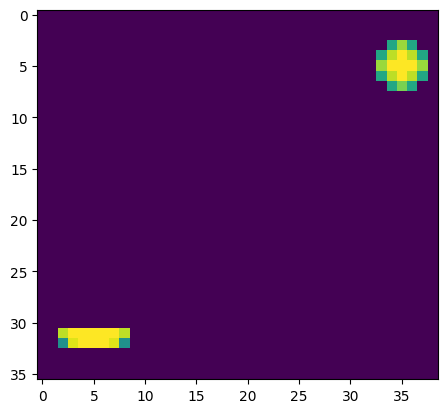

tensor(0, device='cuda:0')


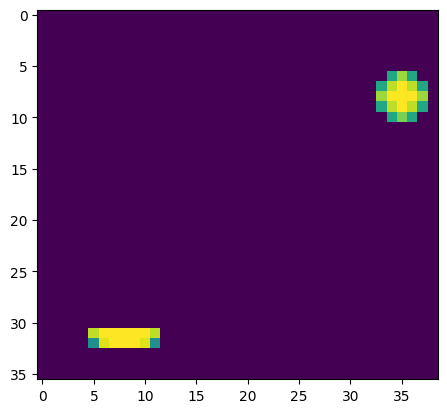

tensor(1, device='cuda:0')


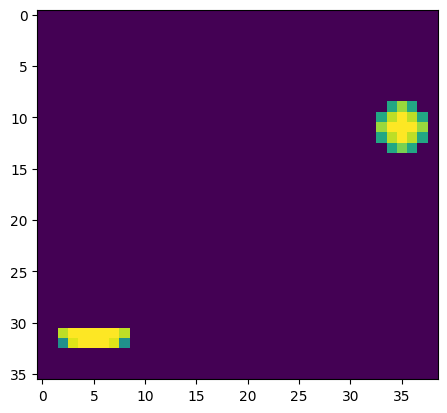

tensor(0, device='cuda:0')


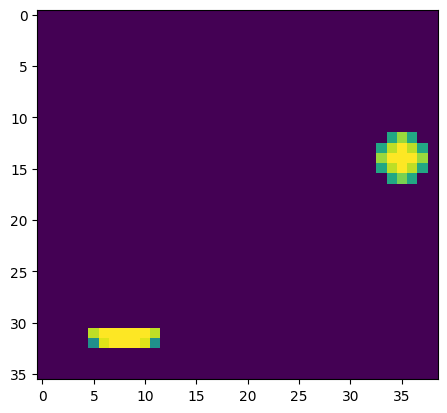

tensor(1, device='cuda:0')


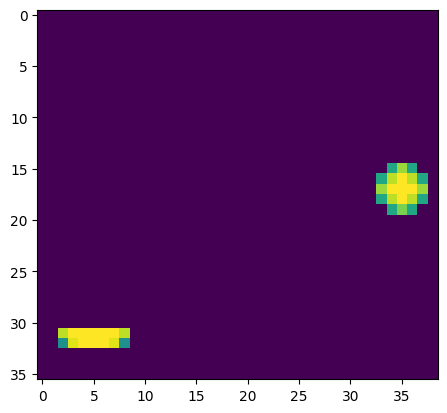

tensor(1, device='cuda:0')


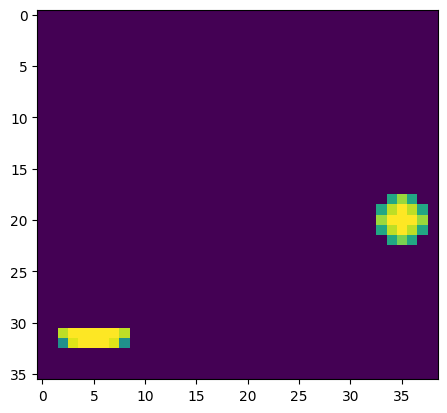

tensor(1, device='cuda:0')


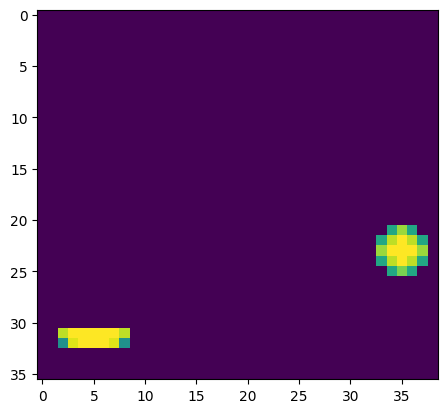

tensor(0, device='cuda:0')


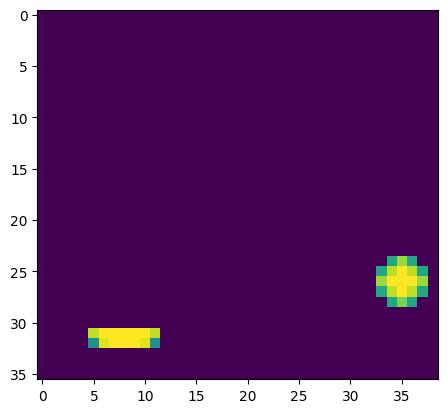

tensor(1, device='cuda:0')


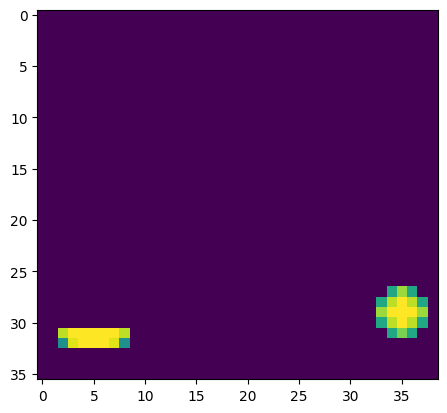

tensor(1, device='cuda:0')


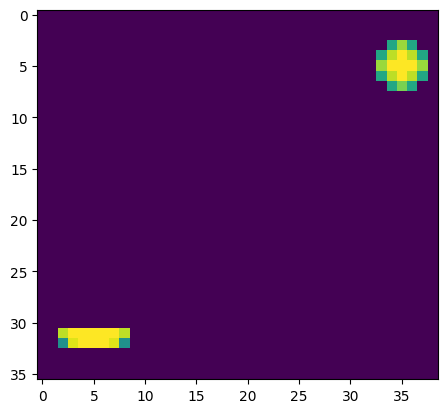

tensor(0, device='cuda:0')


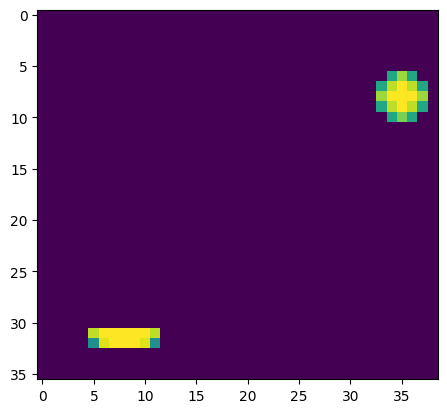

tensor(1, device='cuda:0')


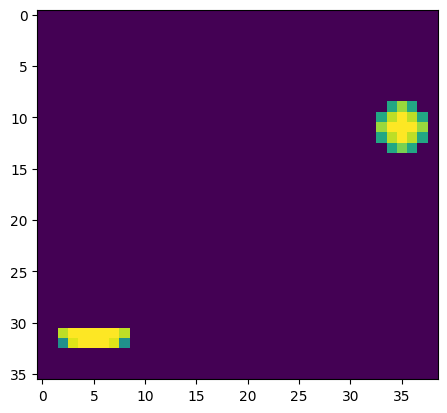

tensor(0, device='cuda:0')


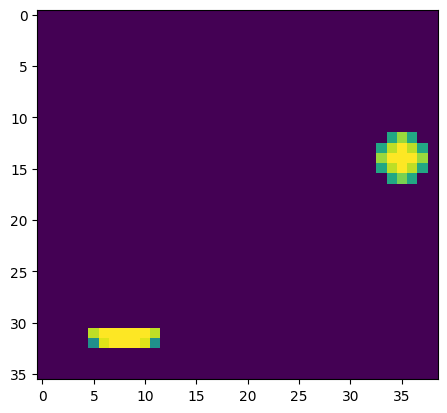

tensor(1, device='cuda:0')


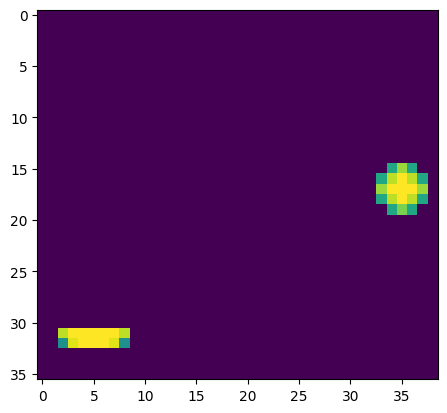

tensor(1, device='cuda:0')


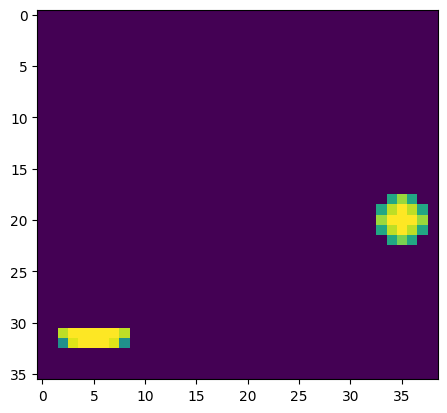

tensor(1, device='cuda:0')


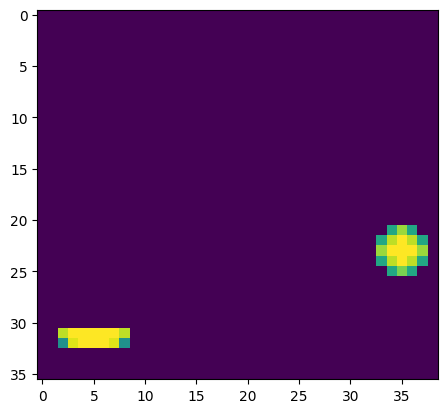

tensor(0, device='cuda:0')


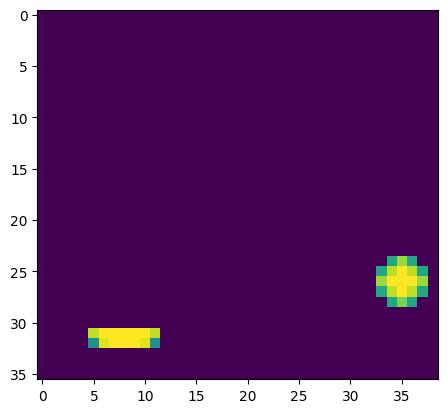

tensor(1, device='cuda:0')


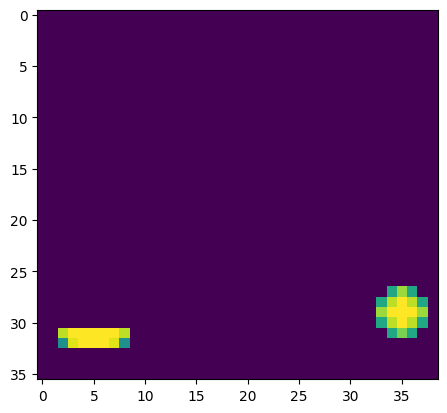

tensor(1, device='cuda:0')


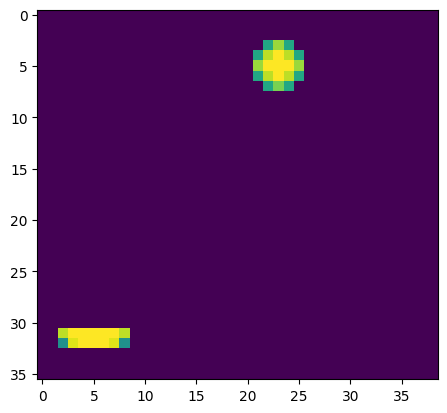

tensor(1, device='cuda:0')


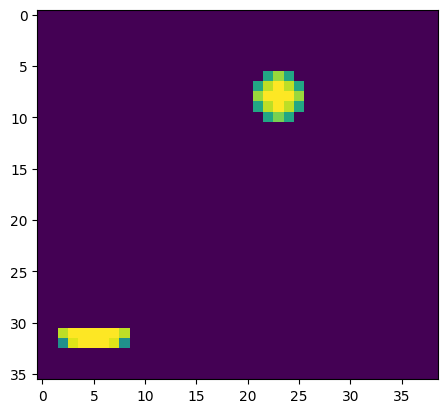

tensor(0, device='cuda:0')


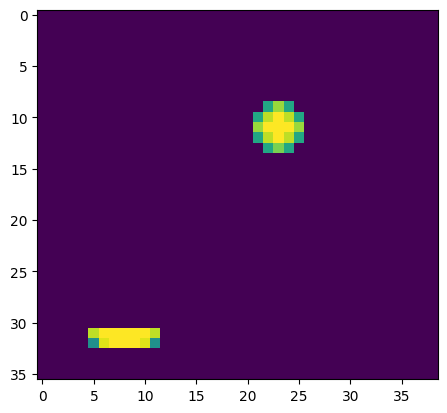

tensor(1, device='cuda:0')


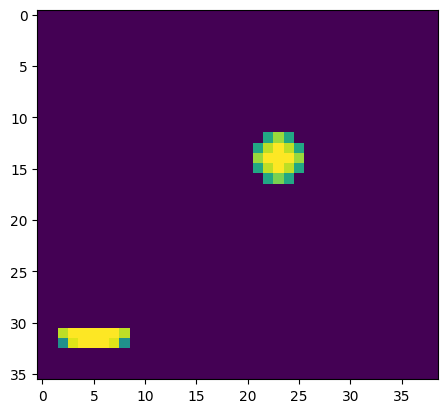

tensor(0, device='cuda:0')


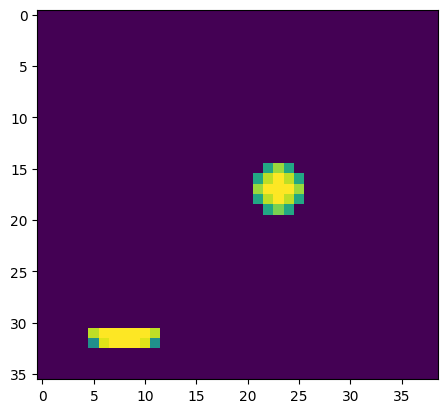

tensor(1, device='cuda:0')


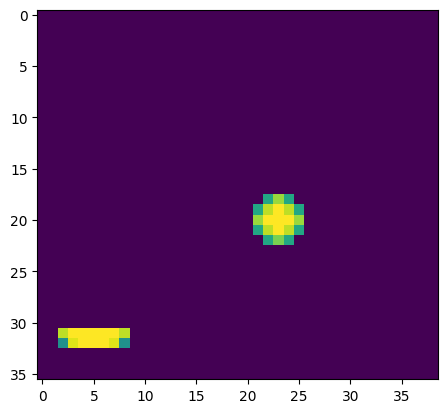

tensor(1, device='cuda:0')


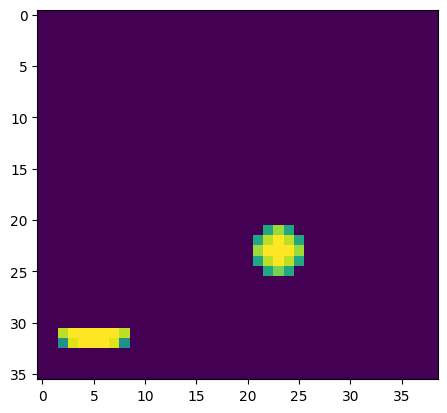

tensor(0, device='cuda:0')


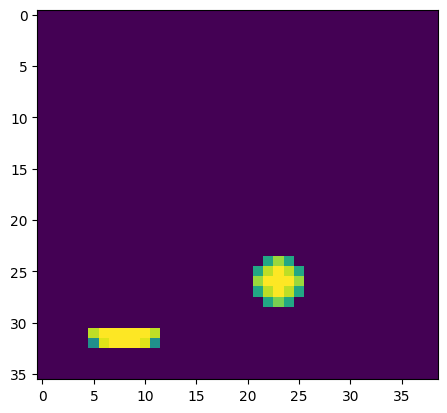

tensor(1, device='cuda:0')


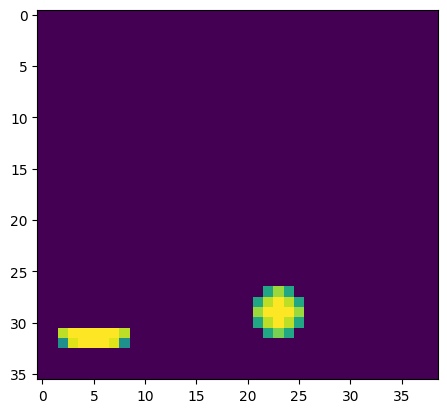

tensor(1, device='cuda:0')


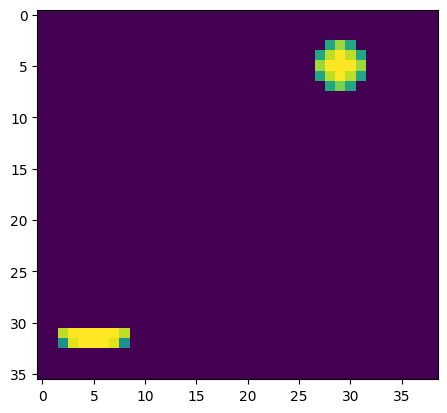

tensor(0, device='cuda:0')


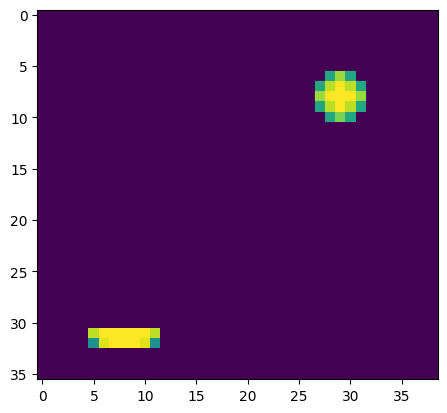

tensor(1, device='cuda:0')


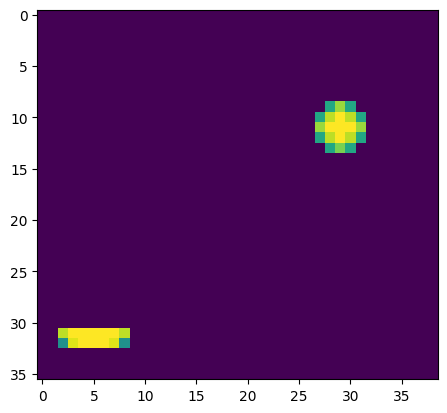

tensor(0, device='cuda:0')


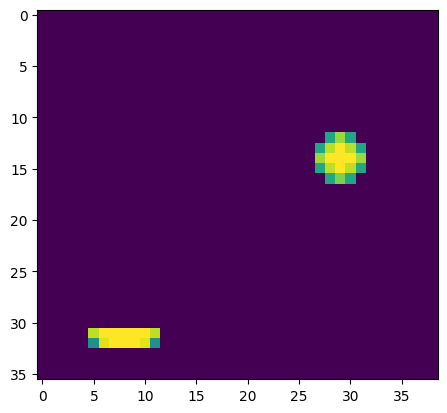

tensor(1, device='cuda:0')


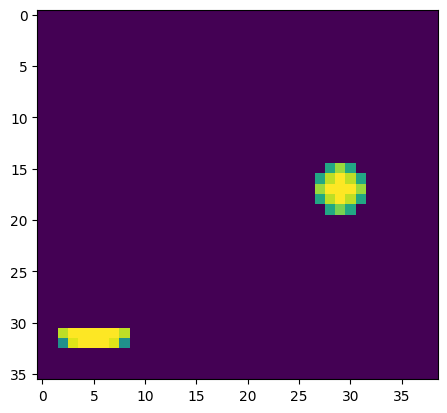

tensor(1, device='cuda:0')


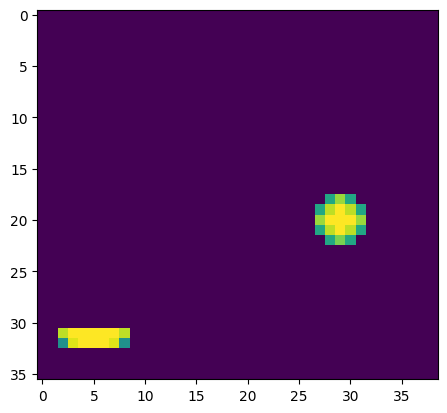

tensor(1, device='cuda:0')


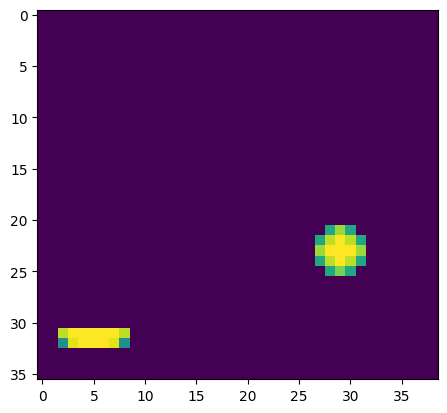

tensor(0, device='cuda:0')


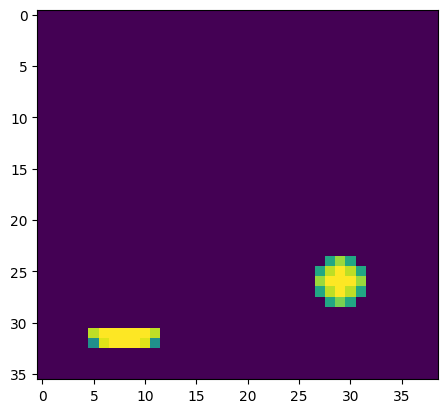

tensor(1, device='cuda:0')


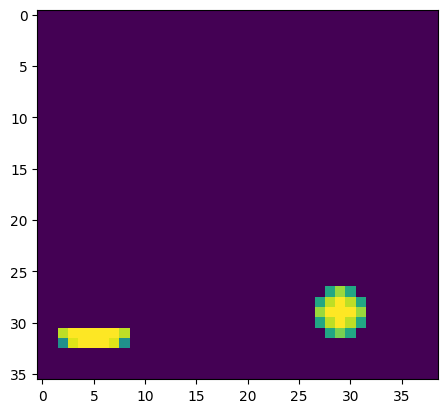

tensor(1, device='cuda:0')


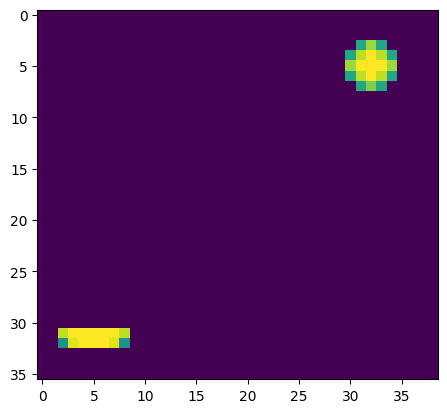

tensor(0, device='cuda:0')


In [9]:
%matplotlib inline
height = (env._height + 2)*3
width = (env._width + 2)*3
for i in range(100):
    obs = env.observe()
    _obs = obs[0]
    plt.figure()
    plt.imshow(np.flip(_obs.squeeze()))
    plt.show()
    if is_terminal: break
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward, _ = agent._step()
    print(action)
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()

In [ ]:
agent._Vs_on_last_episode